In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular_mod
import matplotlib.pyplot as plt
import doc.mod.utils.DatasetRepository as dr
from sklearn.model_selection import train_test_split

import importlib
importlib.reload(dr)
repo = dr.DatasetRepository("../data")

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

## Load Titanic dataset

In [27]:
data = pd.read_csv("../data/titanic/train.csv").set_index("PassengerId")
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [28]:
data["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [42]:
preprocessed_data = data.drop(columns=["Name", "Ticket"])
preprocessed_data["cabin_level"] = data["Cabin"].str[0]
preprocessed_data.drop(columns=["Cabin"], inplace=True)
preprocessed_data["Age"] = preprocessed_data["Age"].fillna(preprocessed_data["Age"].mean())

# categorical features handling
preprocessed_data["Sex"] = preprocessed_data["Sex"].map({
    "female": 0,
    "male": 1
})
preprocessed_data = pd.concat(
    [
        preprocessed_data.drop(columns=["Embarked"]),
        pd.get_dummies(preprocessed_data["Embarked"].fillna("unknown"), prefix="embarked")
    ],
    axis=1
)
preprocessed_data = pd.concat(
    [
        preprocessed_data.drop(columns=["cabin_level"]),
        pd.get_dummies(preprocessed_data["cabin_level"].fillna("unknown"), prefix="cabin_level")
    ],
    axis=1
)
preprocessed_data.info()
preprocessed_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Survived             891 non-null    int64  
 1   Pclass               891 non-null    int64  
 2   Sex                  891 non-null    int64  
 3   Age                  891 non-null    float64
 4   SibSp                891 non-null    int64  
 5   Parch                891 non-null    int64  
 6   Fare                 891 non-null    float64
 7   embarked_C           891 non-null    uint8  
 8   embarked_Q           891 non-null    uint8  
 9   embarked_S           891 non-null    uint8  
 10  embarked_unknown     891 non-null    uint8  
 11  cabin_level_A        891 non-null    uint8  
 12  cabin_level_B        891 non-null    uint8  
 13  cabin_level_C        891 non-null    uint8  
 14  cabin_level_D        891 non-null    uint8  
 15  cabin_level_E        891 non-null    uin

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,embarked_unknown,cabin_level_A,cabin_level_B,cabin_level_C,cabin_level_D,cabin_level_E,cabin_level_F,cabin_level_G,cabin_level_T,cabin_level_unknown
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,3,1,22.000000,1,0,7.2500,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,1,0,38.000000,1,0,71.2833,1,0,0,0,0,0,1,0,0,0,0,0,0
3,1,3,0,26.000000,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,0,0,1
4,1,1,0,35.000000,1,0,53.1000,0,0,1,0,0,0,1,0,0,0,0,0,0
5,0,3,1,35.000000,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,1,27.000000,0,0,13.0000,0,0,1,0,0,0,0,0,0,0,0,0,1
888,1,1,0,19.000000,0,0,30.0000,0,0,1,0,0,1,0,0,0,0,0,0,0
889,0,3,0,29.699118,1,2,23.4500,0,0,1,0,0,0,0,0,0,0,0,0,1


In [ ]:
train, test = train_test_split(
    preprocessed_data, test_size=0.1, stratify=preprocessed_data["Survived"])
train_labels = train.pop("Survived")
test_labels = test.pop("Survived")
train


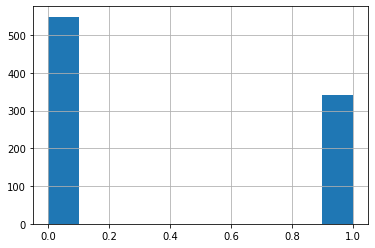

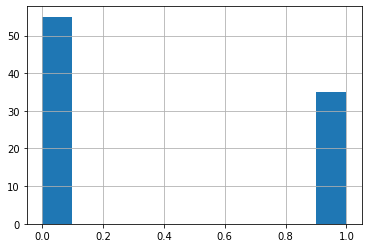

In [25]:
data["Survived"].hist()
plt.show()
test_labels.hist()
plt.show()

In [26]:
model = sklearn.ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
x = train.to_numpy()
y = train_labels.to_numpy()
model.fit(x, y)


ValueError: could not convert string to float: 'female'

## Load fetal health dataset

In [44]:
data = pd.read_csv("../data/fetal_health/fetal_health.csv")
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [48]:
preprocessed_data = data.copy()
# preprocessed_data["fetal_health"] = preprocessed_data["fetal_health"].map({
#     1: "Normal",
#     2: "Suspect",
#     3: "Pathological"
# })
preprocessed_data.info()
preprocessed_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [46]:
train, test = train_test_split(
    preprocessed_data, test_size=0.2, stratify=preprocessed_data["fetal_health"])
train_labels = train.pop("fetal_health")
test_labels = test.pop("fetal_health")
train

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
1792,121.0,0.000,0.001,0.003,0.011,0.001,0.000,67.0,2.1,0.0,0.0,102.0,55.0,157.0,4.0,1.0,67.0,81.0,87.0,89.0,-1.0
336,137.0,0.000,0.016,0.000,0.000,0.000,0.000,64.0,0.5,12.0,10.9,85.0,68.0,153.0,2.0,0.0,143.0,142.0,143.0,3.0,1.0
60,146.0,0.005,0.000,0.005,0.000,0.000,0.000,39.0,0.9,18.0,5.2,44.0,134.0,178.0,5.0,0.0,154.0,154.0,155.0,4.0,0.0
1464,148.0,0.000,0.000,0.006,0.000,0.000,0.000,51.0,0.5,62.0,4.5,8.0,155.0,163.0,1.0,0.0,160.0,159.0,161.0,0.0,0.0
1523,133.0,0.000,0.000,0.007,0.001,0.000,0.000,27.0,1.4,1.0,18.8,56.0,96.0,152.0,5.0,0.0,136.0,134.0,137.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,125.0,0.005,0.002,0.006,0.009,0.000,0.000,60.0,1.3,0.0,7.5,96.0,68.0,164.0,6.0,1.0,110.0,120.0,120.0,34.0,0.0
2032,129.0,0.000,0.001,0.006,0.006,0.000,0.002,66.0,3.2,0.0,0.0,96.0,50.0,146.0,8.0,0.0,105.0,82.0,108.0,10.0,0.0
1045,125.0,0.004,0.000,0.006,0.000,0.000,0.000,36.0,0.9,4.0,6.5,45.0,115.0,160.0,2.0,0.0,131.0,131.0,131.0,3.0,0.0
100,125.0,0.005,0.000,0.002,0.003,0.000,0.000,25.0,1.7,6.0,11.6,93.0,72.0,165.0,3.0,0.0,133.0,128.0,132.0,10.0,0.0


## Load wines dataset

In [49]:
data = pd.read_csv("../data/wine_quality/winequality-red.csv")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [51]:
preprocessed_data = data.copy()
preprocessed_data.info()
preprocessed_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
train, test = train_test_split(
    preprocessed_data, test_size=0.1, stratify=preprocessed_data["quality"])
train_labels = train.pop("quality")
test_labels = test.pop("quality")
train

## Load mushrooms dataset

In [52]:
data = pd.read_csv("../data/mushrooms/mushrooms.csv")
data

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,e,?,s,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,t,?,s,k,w,w,p,w,o,e,w,v,l


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [54]:
import re
legend = """
    cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
    cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
    cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
    bruises: bruises=t,no=f
    odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
    gill-attachment: attached=a,descending=d,free=f,notched=n
    gill-spacing: close=c,crowded=w,distant=d
    gill-size: broad=b,narrow=n
    gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
    stalk-shape: enlarging=e,tapering=t
    stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
    stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
    stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
    stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
    veil-type: partial=p,universal=u
    veil-color: brown=n,orange=o,white=w,yellow=y
    ring-number: none=n,one=o,two=t
    ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
    spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
    population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
    habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d
"""
dict_str = {}
for line in legend.splitlines():
    column_match = re.findall(r"([\w-]+):", line)
    mapping_match = re.findall(r"(\w+=\w)", line)
    if len(column_match) == 1:
        column = column_match[0]
    else:
        continue
    str_representation = "{"
    for mapping in mapping_match:
        inner_mapping_match = re.findall(r"(\w+)", mapping)
        key = inner_mapping_match[1]
        value = inner_mapping_match[0]
        str_representation += f"'{key}': '{value}', "
    str_representation = str_representation[:-2] + "}"
    dict_str[column] = str_representation

In [55]:
preprocessed_data = data.copy()
preprocessed_data["class"] = preprocessed_data["class"].map({
    "e": "edible",
    "p": "poisonous"
})
for column, mapping in dict_str.items():
    preprocessed_data[column] = preprocessed_data[column].map(eval(mapping))
preprocessed_data

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,edible,knobbed,smooth,brown,no,none,attached,close,broad,yellow,enlarging,NaN,smooth,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8120,edible,convex,smooth,brown,no,none,attached,close,broad,yellow,enlarging,NaN,smooth,smooth,orange,orange,partial,brown,one,pendant,buff,several,leaves
8121,edible,flat,smooth,brown,no,none,attached,close,broad,brown,enlarging,NaN,smooth,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8122,poisonous,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,tapering,NaN,smooth,silky,white,white,partial,white,one,evanescent,white,several,leaves


In [56]:
# categorical features handling
preprocessed_data["class"] = preprocessed_data["class"].map({
    "edible": 0,
    "poisonous": 1
})
for column in preprocessed_data.columns.tolist()[1:]:
    preprocessed_data = pd.concat(
        [
            preprocessed_data.drop(columns=[column]),
            pd.get_dummies(preprocessed_data[column].fillna("unknown"), prefix=column)
        ],
        axis=1
    )
preprocessed_data

,class,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,cap-color_brown,cap-color_buff,cap-color_cinnamon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,cap-color_white,cap-color_yellow,bruises_bruises,bruises_no,odor_almond,odor_anise,odor_creosote,odor_fishy,odor_foul,odor_musty,odor_none,odor_pungent,odor_spicy,gill-attachment_attached,gill-attachment_free,gill-spacing_close,gill-spacing_crowded,gill-size_broad,gill-size_narrow,gill-color_black,gill-color_brown,gill-color_buff,gill-color_chocolate,gill-color_gray,gill-color_green,gill-color_orange,gill-color_pink,gill-color_purple,gill-color_red,gill-color_white,gill-color_yellow,stalk-shape_enlarging,stalk-shape_tapering,stalk-root_bulbous,stalk-root_club,stalk-root_equal,stalk-root_rooted,stalk-root_unknown,stalk-surface-above-ring_fibrous,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_fibrous,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,stalk-color-above-ring_brown,stalk-color-above-ring_buff,stalk-color-above-ring_cinnamon,stalk-color-above-ring_gray,stalk-color-above-ring_orange,stalk-color-above-ring_pink,stalk-color-above-ring_red,stalk-color-above-ring_white,stalk-color-above-ring_yellow,stalk-color-below-ring_brown,stalk-color-below-ring_buff,stalk-color-below-ring_cinnamon,stalk-color-below-ring_gray,stalk-color-below-ring_orange,stalk-color-below-ring_pink,stalk-color-below-ring_red,stalk-color-below-ring_white,stalk-color-below-ring_yellow,veil-type_partial,veil-color_brown,veil-color_orange,veil-color_white,veil-color_yellow,ring-number_none,ring-number_one,ring-number_two,ring-type_evanescent,ring-type_flaring,ring-type_large,ring-type_none,ring-type_pendant,spore-print-color_black,spore-print-color_brown,spore-print-color_buff,spore-print-color_chocolate,spore-print-color_green,spore-print-color_orange,spore-print-color_purple,spore-print-color_white,spore-print-color_yellow,population_abundant,population_clustered,population_numerous,population_scattered,population_several,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [15]:
train, test = train_test_split(
    preprocessed_data, test_size=0.2, stratify=preprocessed_data["class"])
train_labels = train.pop("class")
test_labels = test.pop("class")
train

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
6393,flat,scaly,brown,no,fishy,free,close,narrow,buff,tapering,NaN,silky,smooth,white,white,partial,white,one,evanescent,white,several,woods
768,bell,scaly,yellow,bruises,almond,free,close,broad,gray,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,scattered,meadows
543,convex,scaly,yellow,bruises,almond,free,close,broad,pink,enlarging,rooted,smooth,scaly,white,white,partial,white,one,pendant,black,scattered,grasses
3387,flat,fibrous,red,bruises,none,free,close,broad,brown,tapering,bulbous,smooth,smooth,gray,white,partial,white,one,pendant,brown,several,woods
6667,convex,smooth,red,no,spicy,free,close,narrow,buff,tapering,NaN,silky,smooth,pink,pink,partial,white,one,evanescent,white,several,woods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7696,knobbed,scaly,red,no,foul,free,close,narrow,buff,tapering,NaN,smooth,smooth,pink,pink,partial,white,one,evanescent,white,several,woods
1918,flat,fibrous,brown,no,none,free,crowded,broad,black,tapering,equal,smooth,fibrous,white,white,partial,white,one,evanescent,black,scattered,grasses
1553,flat,fibrous,white,no,none,free,crowded,broad,brown,tapering,equal,fibrous,fibrous,white,white,partial,white,one,evanescent,black,abundant,grasses
511,bell,scaly,yellow,bruises,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,grasses


## Load heart disease dataset

In [57]:
data = pd.read_csv("../data/heart/heart.csv")
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [58]:
preprocessed_data = data.copy()
preprocessed_data.info()
preprocessed_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [ ]:
train, test = train_test_split(
    preprocessed_data, test_size=0.1, stratify=preprocessed_data["target"])
train_labels = train.pop("target")
test_labels = test.pop("target")
train

In [20]:
train_data, train_labels, test_data, test_labels = repo.get_wines_dataset()
train_data


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1160,10.6,0.360,0.57,2.3,0.087,6.0,20.0,0.99676,3.14,0.72,11.1
131,5.6,0.500,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0
663,10.1,0.280,0.46,1.8,0.050,5.0,13.0,0.99740,3.04,0.79,10.2
854,9.3,0.360,0.39,1.5,0.080,41.0,55.0,0.99652,3.47,0.73,10.9
301,11.1,0.180,0.48,1.5,0.068,7.0,15.0,0.99730,3.22,0.64,10.1
...,...,...,...,...,...,...,...,...,...,...,...
172,8.0,0.420,0.17,2.0,0.073,6.0,18.0,0.99720,3.29,0.61,9.2
1193,6.4,0.885,0.00,2.3,0.166,6.0,12.0,0.99551,3.56,0.51,10.8
372,9.1,0.280,0.48,1.8,0.067,26.0,46.0,0.99670,3.32,1.04,10.6
117,7.8,0.560,0.12,2.0,0.082,7.0,28.0,0.99700,3.37,0.50,9.4
